# Notebook used to test our RAG chatbot package on the `rag-mini-bioasq` dataset

## Setup and dataset download

In [1]:
import gc

import torch
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_text_splitters import RecursiveCharacterTextSplitter, CharacterTextSplitter

from nlp_chat_bot.doc_loader.test_data_csv_loader import TestDataCSVLoader
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_text_splitters import RecursiveCharacterTextSplitter

from nlp_chat_bot.model.embedding.minilm import MiniLM
from nlp_chat_bot.model.llm.gemma import Gemma
from nlp_chat_bot.model.llm.mistral import Mistral
from nlp_chat_bot.rag.classic_rag import ClassicRAG
from nlp_chat_bot.rag.query_translation_rag_decomposition import QueryTranslationRAGDecomposition
from nlp_chat_bot.rag.query_translation_rag_fusion import QueryTranslationRAGFusion
from nlp_chat_bot.vector_store.late_chunking_chroma_vector_store_builder import LateChunkingChromaVectorStoreBuilder
from nlp_chat_bot.vector_store.naive_chunking_chroma_vector_store_builder import NaiveChunkingChromaVectorStoreBuilder
from datasets import load_dataset, tqdm
from nlp_chat_bot.model.embedding.late_chunking_embedding import LateChunkingEmbedding
from dotenv import load_dotenv
load_dotenv()

d:\Programs\Anaconda\envs\nlp_project_chatbot\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


True

In [2]:
ds_qa = load_dataset("enelpol/rag-mini-bioasq", "question-answer-passages")["test"]
ds_corpus = load_dataset("enelpol/rag-mini-bioasq", "text-corpus")["test"]

# only keep ds_qa rows with 3 items or more because we use 3 by default in our case
ds_qa = ds_qa.filter(lambda x: len(x["relevant_passage_ids"]) >= 3)

# we remove extra \n from passages 
ds_corpus = ds_corpus.map(lambda row: {"passage": row["passage"].replace("\n", " ")})

ds_qa.to_csv("../test_datasets/rag-mini-bioasq/qa/qa.csv")
ds_corpus.to_csv("../test_datasets/rag-mini-bioasq/corpus/corpus.csv")

Creating CSV from Arrow format: 100%|██████████| 41/41 [00:00<00:00, 50.85ba/s]


60209211

In [3]:
print("Datasets sizes:")
print(f"ds_qa: {len(ds_qa)}")
print(f"ds_corpus: {len(ds_corpus)}")

Datasets sizes:
ds_qa: 497
ds_corpus: 40181


In [4]:
import pandas as pd
df = pd.DataFrame(ds_corpus)
df.head(1)

df = pd.DataFrame(ds_qa)
df.head(1)

,question,answer,id,relevant_passage_ids
0,Describe the mechanism of action of ibalizumab.,Ibalizumab is a humanized monoclonal antibody ...,2835,"[29675744, 24853313, 29689540, 21289125, 20698..."


In [5]:
# test if our Llama installation supports GPU

# import os
# from llama_cpp.llama_cpp import load_shared_library
# import llama_cpp
# 
# llama_root_path_module = os.path.dirname(llama_cpp.__file__)
# import pathlib
# 
# def is_gpu_available_v3() -> bool:
# 
#     lib = load_shared_library('llama',pathlib.Path(llama_root_path_module+'/lib'))
#     return bool(lib.llama_supports_gpu_offload())
# 
# print(is_gpu_available_v3())

In [6]:
def test_retrieval(ds_qa, retrieve_function):
    total_num_documents_considered = 0
    num_valid_docs = 0
    for test_item in tqdm(ds_qa):
        question = test_item["question"]
        expected_documents_ids = test_item["relevant_passage_ids"]
        
        response = retrieve_function(state = {"question": question, "context": []})
        docs_retrieved = response["context"]        
        
        # print("Question:",question)
        # print("Retrieved:",docs_retrieved)
        # print("#########################\n\n")
        # if it's a dict of docs (e.g. with QueryTranslationRAGDecomposition)
        if isinstance(docs_retrieved, dict):
            num_docs_retrieved = 0
            for _, docs in docs_retrieved.items():
                num_docs_retrieved += len(docs)
                for doc in docs:
                    if int(doc.metadata["id"]) in expected_documents_ids:
                        num_valid_docs += 1
            total_num_documents_considered += min(len(expected_documents_ids), num_docs_retrieved)
        else:
            num_documents_considered = min(len(expected_documents_ids), len(docs_retrieved))
            total_num_documents_considered += num_documents_considered
            # print("Expected:",expected_documents_ids,"Got:",[doc.metadata["id"] for doc in docs_retrieved])
            # print("Expected:",expected_documents_ids)
            for doc in docs_retrieved:
                # print("Got:",doc.metadata["id"])
                if int(doc.metadata["id"]) in expected_documents_ids:
                    num_valid_docs += 1
        
        
    return num_valid_docs / total_num_documents_considered

## Tests

In [7]:
scores = {}

In [8]:
corpus_path = "../test_datasets/rag-mini-bioasq/corpus"
vector_store_path = "../test_chromadb"
model_download_path = "../models"
reload_vector_store = True # Add non existing documents
reset_vector_store = False # Remove previous documents

# splitter = None
splitter = RecursiveCharacterTextSplitter(
    chunk_size=1000,  # chunk size (characters)
    chunk_overlap=0,  # chunk overlap (characters)
)

llm = Gemma(model_download_path=model_download_path)
# llm = ChatGoogleGenerativeAI(model="gemini-1.5-flash")

ggml_cuda_init: GGML_CUDA_FORCE_MMQ:    no
ggml_cuda_init: GGML_CUDA_FORCE_CUBLAS: no
ggml_cuda_init: found 1 CUDA devices:
  Device 0: NVIDIA GeForce RTX 3060, compute capability 8.6, VMM: yes
llama_model_load_from_file: using device CUDA0 (NVIDIA GeForce RTX 3060) - 11247 MiB free
llama_model_loader: loaded meta data with 39 key-value pairs and 288 tensors from ../models\gemma-2-2b-it-GGUF\models--MaziyarPanahi--gemma-2-2b-it-GGUF\snapshots\bd652eddf75b473fe86639b6b927e06972277d1a\gemma-2-2b-it.IQ1_M.gguf (version GGUF V3 (latest))
llama_model_loader: Dumping metadata keys/values. Note: KV overrides do not apply in this output.
llama_model_loader: - kv   0:                       general.architecture str              = gemma2
llama_model_loader: - kv   1:                               general.type str              = model
llama_model_loader: - kv   2:                               general.name str              = Models Google Gemma 2 2b It
llama_model_loader: - kv   3:                

### MiniLM, Naive Chunking

In [9]:
embedding_function = MiniLM(model_download_path=model_download_path)

vector_store = NaiveChunkingChromaVectorStoreBuilder(corpus_path, embedding_function, vector_store_path, splitter, document_loader=TestDataCSVLoader()).build(reload_vector_store, reset_vector_store)

rag = ClassicRAG(vector_store, llm=llm)

scores["MiniLM-NaiveChunking-Gemma"] = test_retrieval(ds_qa, rag.retrieve)
print(scores["MiniLM-NaiveChunking-Gemma"])

100%|██████████| 1/1 [00:00<00:00,  1.24it/s]
Storing documents embeddings (batch size is 1000): 0it [00:00, ?it/s]
d:\Programs\Anaconda\envs\nlp_project_chatbot\lib\site-packages\langsmith\client.py:256: LangSmithMissingAPIKeyWarning: API key must be provided when using hosted LangSmith API
  warnings.warn(


Documents are now loaded


100%|██████████| 497/497 [00:03<00:00, 154.66it/s]

0.5030181086519114


### Jina, Late Chunking

Here we should note that we use Late Chunking on small documents, which is not the best use case for Late Chunking, so we can't really evaluate the performance of Late Chunking here.

In [10]:
embedding_function = LateChunkingEmbedding(model_download_path=model_download_path)

vector_store = LateChunkingChromaVectorStoreBuilder(corpus_path, embedding_function, vector_store_path, splitter, document_loader=TestDataCSVLoader()).build(reload_vector_store, reset_vector_store)

rag = ClassicRAG(vector_store, llm=llm)

scores["Jina-LateChunking-Gemma"] = test_retrieval(ds_qa, rag.retrieve)
print(scores["Jina-LateChunking-Gemma"])

100%|██████████| 1/1 [00:00<00:00,  1.66it/s]
Storing 40182 documents embeddings (batch size is 100): 40200it [07:07, 94.14it/s]                            
d:\Programs\Anaconda\envs\nlp_project_chatbot\lib\site-packages\langsmith\client.py:256: LangSmithMissingAPIKeyWarning: API key must be provided when using hosted LangSmith API
  warnings.warn(


Documents are now loaded


100%|██████████| 497/497 [00:03<00:00, 150.70it/s]

0.3983903420523139


### MiniLM, Naive Chunking, Query Translation RAG Decomposition

The score is worse here, it's likely because of the LLM used (Gemma), that is not big enough (and quantized)

In [11]:
embedding_function = MiniLM(model_download_path=model_download_path)

vector_store = NaiveChunkingChromaVectorStoreBuilder(corpus_path, embedding_function, vector_store_path, splitter, document_loader=TestDataCSVLoader()).build(reload_vector_store, reset_vector_store)

rag = QueryTranslationRAGDecomposition(vector_store, llm=llm)

scores["MiniLM-NaiveChunking-Gemma-Decomposition"] = test_retrieval(ds_qa, rag.retrieve)
print(scores["MiniLM-NaiveChunking-Gemma-Decomposition"])

100%|██████████| 1/1 [00:00<00:00,  1.57it/s]
Storing documents embeddings (batch size is 1000): 0it [00:00, ?it/s]
d:\Programs\Anaconda\envs\nlp_project_chatbot\lib\site-packages\langsmith\client.py:256: LangSmithMissingAPIKeyWarning: API key must be provided when using hosted LangSmith API
  warnings.warn(


Documents are now loaded


  0%|          | 0/497 [00:00<?, ?it/s]C:\CYTechNVME\nlp_project_chatbot\src\nlp_chat_bot\model\llm\gemma.py:31: LangChainDeprecationWarning: The method `BaseLLM.__call__` was deprecated in langchain-core 0.1.7 and will be removed in 1.0. Use :meth:`~invoke` instead.
  return AIMessage(self._llm(prompt.messages[0].content))
llama_perf_context_print:        load time =     907.34 ms
llama_perf_context_print: prompt eval time =       0.00 ms /    94 tokens (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /   299 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =    3762.43 ms /   393 tokens
  0%|          | 1/497 [00:04<34:12,  4.14s/it]Llama.generate: 83 prefix-match hit, remaining 20 prompt tokens to eval
llama_perf_context_print:        load time =     907.34 ms
llama_perf_context_print: prompt eval time =       0.00 ms /    20 tokens (    0.00 ms per token,      inf toke

0.2391132224861441


### MiniLM, Naive Chunking, Query Translation RAG Fusion

The score is really bad here, it's likely because of the LLM used (Gemma), that is not big enough (and quantized). And contrarily to the previous case, we have even more calls to the LLM hence the error propagates

In [12]:
embedding_function = MiniLM(model_download_path=model_download_path)

vector_store = NaiveChunkingChromaVectorStoreBuilder(corpus_path, embedding_function, vector_store_path, splitter, document_loader=TestDataCSVLoader()).build(reload_vector_store, reset_vector_store)

rag = QueryTranslationRAGFusion(vector_store, llm=llm)

scores["MiniLM-NaiveChunking-Gemma-Fusion"] = test_retrieval(ds_qa, rag.retrieve)
print(scores["MiniLM-NaiveChunking-Gemma-Fusion"])

100%|██████████| 1/1 [00:00<00:00,  1.67it/s]
Storing documents embeddings (batch size is 1000): 0it [00:00, ?it/s]
d:\Programs\Anaconda\envs\nlp_project_chatbot\lib\site-packages\langsmith\client.py:256: LangSmithMissingAPIKeyWarning: API key must be provided when using hosted LangSmith API
  warnings.warn(


Documents are now loaded


  0%|          | 0/497 [00:00<?, ?it/s]Llama.generate: 83 prefix-match hit, remaining 11 prompt tokens to eval
llama_perf_context_print:        load time =     907.34 ms
llama_perf_context_print: prompt eval time =       0.00 ms /    11 tokens (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /   299 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =    3311.78 ms /   310 tokens
  0%|          | 1/497 [00:03<27:43,  3.35s/it]Llama.generate: 83 prefix-match hit, remaining 20 prompt tokens to eval
llama_perf_context_print:        load time =     907.34 ms
llama_perf_context_print: prompt eval time =       0.00 ms /    20 tokens (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /   299 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =    3528.48 ms /   319 tokens


0.010731052984574111


## With Mistral Instruct instead of Gemma

In [24]:
corpus_path = "../test_datasets/rag-mini-bioasq/corpus"
vector_store_path = "../test_chromadb"
model_download_path = "../models"
reload_vector_store = True # Add non existing documents
reset_vector_store = False # Remove previous documents

# splitter = None
splitter = RecursiveCharacterTextSplitter(
    chunk_size=1000,  # chunk size (characters)
    chunk_overlap=0,  # chunk overlap (characters)
)

# delete previous model from memory
del rag
gc.collect()
torch.cuda.empty_cache()
llm = Mistral(model_download_path=model_download_path) # reset your notebook if it crashes (it probably means you don't have enough memory)

llama_model_load_from_file: using device CUDA0 (NVIDIA GeForce RTX 3060) - 9411 MiB free
llama_model_loader: loaded meta data with 29 key-value pairs and 291 tensors from ../models\Mistral-7B-Instruct-v0.3-GGUF\models--MaziyarPanahi--Mistral-7B-Instruct-v0.3-GGUF\snapshots\ce89f595755a4bf2e2e05d155cc43cb847c78978\Mistral-7B-Instruct-v0.3.Q8_0.gguf (version GGUF V3 (latest))
llama_model_loader: Dumping metadata keys/values. Note: KV overrides do not apply in this output.
llama_model_loader: - kv   0:                       general.architecture str              = llama
llama_model_loader: - kv   1:                               general.name str              = models--mistralai--Mistral-7B-Instruc...
llama_model_loader: - kv   2:                          llama.block_count u32              = 32
llama_model_loader: - kv   3:                       llama.context_length u32              = 32768
llama_model_loader: - kv   4:                     llama.embedding_length u32              = 4096
llam

### MiniLM, Naive Chunking, Query Translation RAG Decomposition

The score is worse here, it's likely because of the LLM used (Gemma), that is not big enough (and quantized)

In [25]:
embedding_function = MiniLM(model_download_path=model_download_path)

vector_store = NaiveChunkingChromaVectorStoreBuilder(corpus_path, embedding_function, vector_store_path, splitter, document_loader=TestDataCSVLoader()).build(reload_vector_store, reset_vector_store)

rag = QueryTranslationRAGDecomposition(vector_store, llm=llm)

scores["MiniLM-NaiveChunking-Mistral-Decomposition"] = test_retrieval(ds_qa, rag.retrieve)
print(scores["MiniLM-NaiveChunking-Mistral-Decomposition"])

100%|██████████| 1/1 [00:00<00:00,  1.58it/s]
Storing documents embeddings (batch size is 1000): 0it [00:00, ?it/s]
d:\Programs\Anaconda\envs\nlp_project_chatbot\lib\site-packages\langsmith\client.py:256: LangSmithMissingAPIKeyWarning: API key must be provided when using hosted LangSmith API
  warnings.warn(


Documents are now loaded


  0%|          | 0/497 [00:00<?, ?it/s]llama_perf_context_print:        load time =     799.57 ms
llama_perf_context_print: prompt eval time =       0.00 ms /    98 tokens (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /   103 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =    4742.86 ms /   201 tokens
  0%|          | 1/497 [00:04<39:22,  4.76s/it]Llama.generate: 86 prefix-match hit, remaining 22 prompt tokens to eval
llama_perf_context_print:        load time =     799.57 ms
llama_perf_context_print: prompt eval time =       0.00 ms /    22 tokens (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /    97 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =    3921.65 ms /   119 tokens
  0%|          | 2/497 [00:08<35:25,  4.29s/it]Llama.generate: 89 prefix

0.42458563535911603


### MiniLM, Naive Chunking, Query Translation RAG Fusion

The score is really bad here, it's likely because of the LLM used (Gemma), that is not big enough (and quantized). And contrarily to the previous case, we have even more calls to the LLM hence the error propagates

In [26]:
embedding_function = MiniLM(model_download_path=model_download_path)

vector_store = NaiveChunkingChromaVectorStoreBuilder(corpus_path, embedding_function, vector_store_path, splitter, document_loader=TestDataCSVLoader()).build(reload_vector_store, reset_vector_store)

rag = QueryTranslationRAGFusion(vector_store, llm=llm)

scores["MiniLM-NaiveChunking-Mistral-Fusion"] = test_retrieval(ds_qa, rag.retrieve)
print(scores["MiniLM-NaiveChunking-Mistral-Fusion"])

100%|██████████| 1/1 [00:00<00:00,  1.70it/s]
Storing documents embeddings (batch size is 1000): 0it [00:00, ?it/s]
d:\Programs\Anaconda\envs\nlp_project_chatbot\lib\site-packages\langsmith\client.py:256: LangSmithMissingAPIKeyWarning: API key must be provided when using hosted LangSmith API
  warnings.warn(


Documents are now loaded


  0%|          | 0/497 [00:00<?, ?it/s]Llama.generate: 86 prefix-match hit, remaining 12 prompt tokens to eval
llama_perf_context_print:        load time =     799.57 ms
llama_perf_context_print: prompt eval time =       0.00 ms /    12 tokens (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /    82 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =    3248.74 ms /    94 tokens
  0%|          | 1/497 [00:03<27:02,  3.27s/it]Llama.generate: 86 prefix-match hit, remaining 22 prompt tokens to eval
llama_perf_context_print:        load time =     799.57 ms
llama_perf_context_print: prompt eval time =       0.00 ms /    22 tokens (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /   104 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =    4184.17 ms /   126 tokens


0.011401743796109993


## All results

It's important here to note that actually for Fusion and Decomposition we should evaluate the completion rather than the retrieval because here the only difference between those two, is that the fusion version only keep the best documents, whereas the other one keeps all the documents.

                                       Method     Score
0                  MiniLM-NaiveChunking-Gemma  0.503018
1                     Jina-LateChunking-Gemma  0.398390
2    MiniLM-NaiveChunking-Gemma-Decomposition  0.239113
3           MiniLM-NaiveChunking-Gemma-Fusion  0.010731
4  MiniLM-NaiveChunking-Mistral-Decomposition  0.424586
5         MiniLM-NaiveChunking-Mistral-Fusion  0.011402


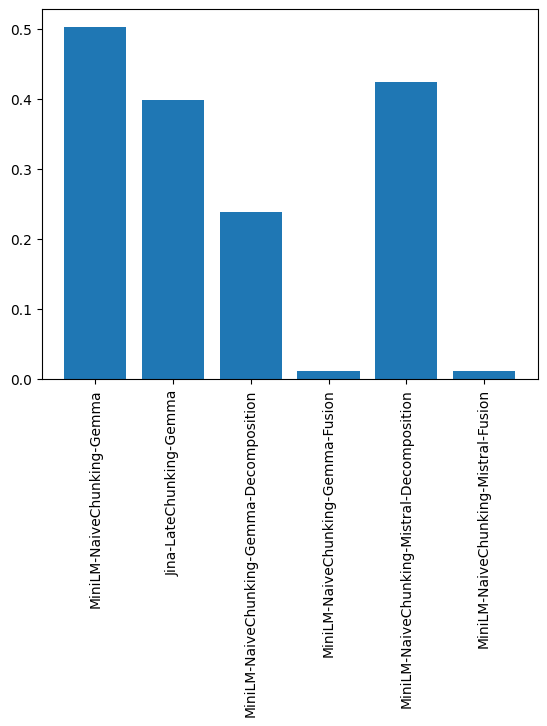

In [27]:
import pandas as pd
import matplotlib.pyplot as plt

df_scores = pd.DataFrame(scores.items(), columns=["Method", "Score"])
print(df_scores)

plt.bar(scores.keys(), scores.values())
plt.xticks(rotation=90)
plt.show()